# Proyecto 03 - Series de Tiempo - Facundo Ríos

## Link del Repositorio: https://github.com/facundorios/TP3





## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### A Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### B Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### C Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### Preparación del Dataset
---

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

import seaborn as sns
sns.set() 

In [3]:
data_2019 = pd.read_csv('Datasets/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('Datasets/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('Datasets/flujo-vehicular-2017.csv', sep =',')

Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [4]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [5]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [6]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [7]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [8]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [9]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [10]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [11]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


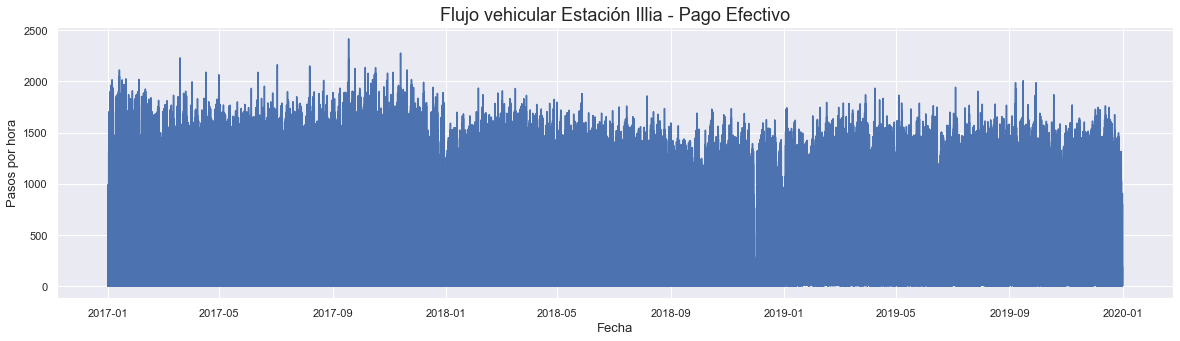

In [12]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (20,5))

plt.plot(dataset.fecha, dataset.cantidad_pasos)

plt.title('Flujo vehicular Estación Illia - Pago Efectivo', size=18)
plt.xlabel('Fecha', size= 13)
plt.ylabel('Pasos por hora', size= 13)
plt.show()

**Figura 1.** Cantidad de pasos de autos por hora en la Estación Illia para forma de pago Efectivo.

Podemos ver que el gráfico se encuentra saturado de información.

In [13]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


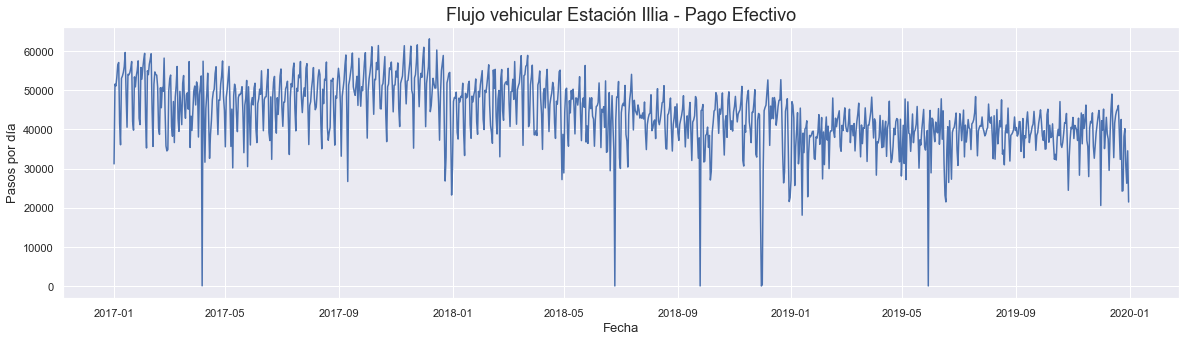

In [14]:
plt.figure(figsize = (20,5))

plt.plot(diario.index, diario.cantidad_pasos)

plt.title('Flujo vehicular Estación Illia - Pago Efectivo', size=18)
plt.xlabel('Fecha', size= 13)
plt.ylabel('Pasos por día', size= 13)
plt.show()

**Figura 2.** Cantidad de pasos de por día en la Estación Illia para forma de pago Efectivo.

Ahora el gráfico es legible y puede verse claramente la presencia de Outliers y una tendencia levemente descendente.

## A Exploración de datos
---

Realizamos una copia de trabajo del dataset:

In [15]:
ds = diario.copy()

### Análisis de Outliers

Ubicamos los Outliers para poder suplantarlos:

In [16]:
print('Cantidad de Outliers: {}'.format((ds['cantidad_pasos']<1000).sum()))

Cantidad de Outliers: 6


In [17]:
ds['cantidad_pasos'][ds['cantidad_pasos']<1000] 

fecha
2017-04-06     40
2018-06-25      0
2018-09-25      0
2018-11-30      0
2018-12-01    350
2019-05-29      0
Name: cantidad_pasos, dtype: int64

Asignamos NaN a estos 6 valores y los reemplazamos interpolando:

In [18]:
ds['cantidad_pasos'][ds['cantidad_pasos']<1000] = np.nan 

ds = ds.interpolate()

Verificamos:

In [19]:
print('Cantidad de Outliers: {}'.format((ds['cantidad_pasos']<1000).sum()))

Cantidad de Outliers: 0


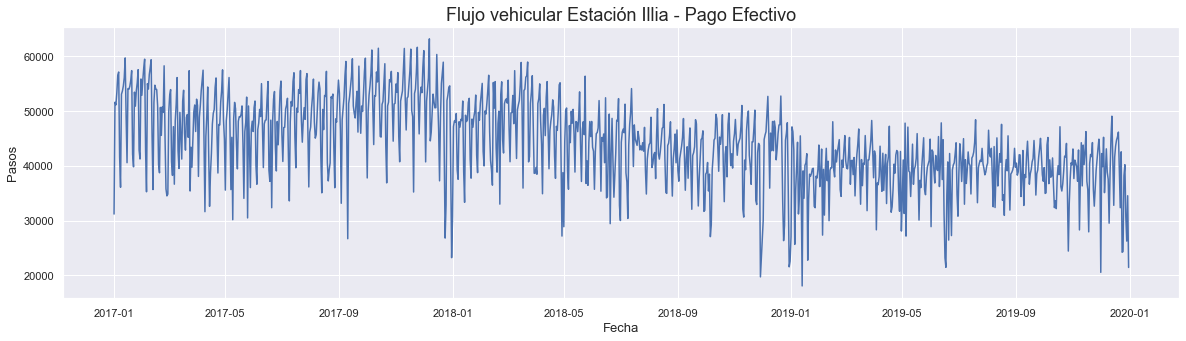

In [20]:
plt.figure(figsize = (20,5))

plt.plot(ds.index, ds.cantidad_pasos)

plt.title('Flujo vehicular Estación Illia - Pago Efectivo', size=18)
plt.xlabel('Fecha', size= 13)
plt.ylabel('Pasos', size= 13)
plt.show()

**Figura 3.** Cantidad de pasos de autos por día en la Estación Illia para forma de pago Efectivo.

Los Outliers fueron correctamente suplantados por valores de interpolación y ya no se ven los picos descendentes en el gráfico.

Verificamos si hay fechas faltantes, para esto hacemos una copia del Dataset y generamos un índice numérico ya que no podemos analizar las fechas en formato `TimeIndex` y sí como un feature más:

In [33]:
ds_index = diario.copy()

In [38]:
ds_index.reset_index(inplace=True)
ds_index.head(2)

,index,fecha,cantidad_pasos
0,0,2017-01-01,31183
1,1,2017-01-02,51568


confirmamos que 'fecha' es ahora una variable más y no el índice, lo que nos permitirá verificar sus valores:

In [39]:
ds_index['date_check'] = ds_index.fecha.diff()
ds_index.date_check.value_counts() 

1 days    1094
Name: date_check, dtype: int64

Podemos ver que la diferencia entre días es igual a 1 a lo largo de toda la serie por lo tanto confirmamos que no hay valores faltantes en las fechas.  
Podemos continuar utilizando el Dataset anterior con fechas como índice.

Verificamos ahora si hay faltantes en al variable 'cantidad_pasos':

In [40]:
ds.isnull().sum()

cantidad_pasos    0
dtype: int64

Confirmamos que tampoco hay faltantes.

### Análisis de Estacionariedad (Stationarity)

Suavizamos la serie con Medias Móviles con distintas ventanas de tiempo (en días) y graficamos:

In [41]:
y_hat_avg = ds.copy()
y_hat_avg['moving_avg_forecast_7'] = y_hat_avg['cantidad_pasos'].rolling(7, center = True).mean() 
y_hat_avg['moving_avg_forecast_14'] = y_hat_avg['cantidad_pasos'].rolling(14, center = True).mean() 
y_hat_avg['moving_avg_forecast_30'] = y_hat_avg['cantidad_pasos'].rolling(30, center = True).mean() 

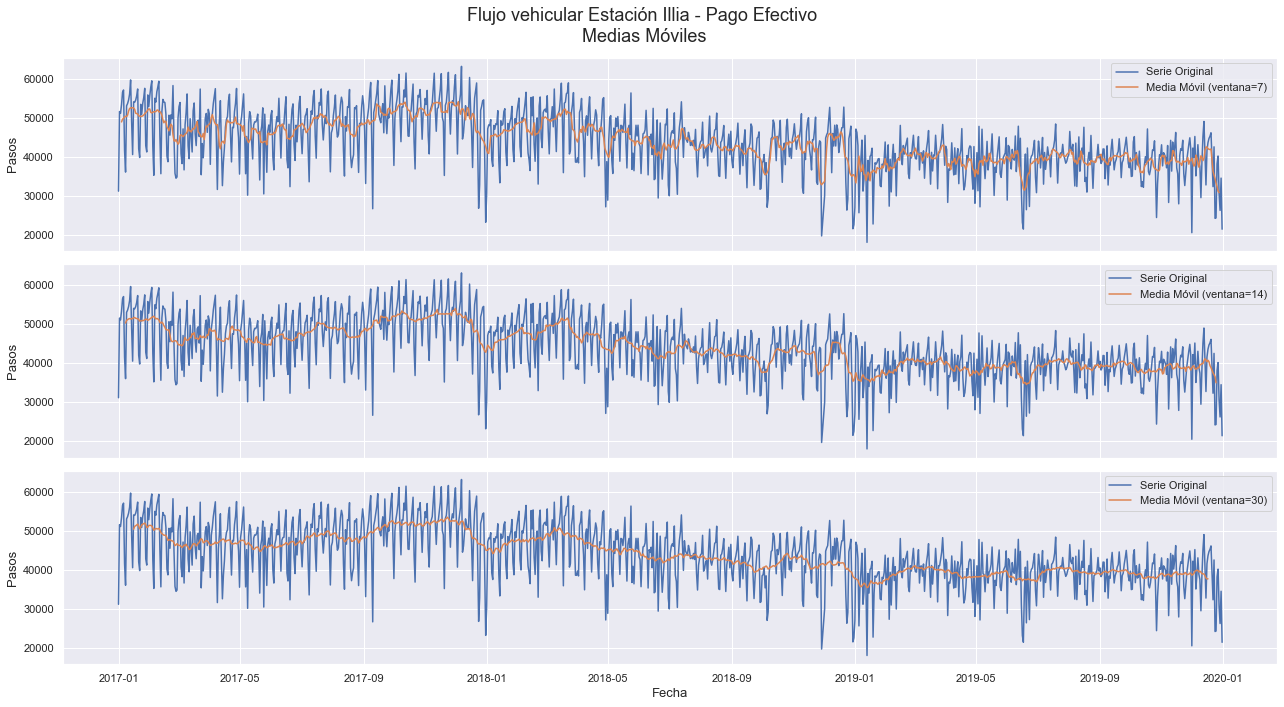

In [42]:
fig, ax = plt.subplots(3, 1, figsize=(18, 10), sharex=True) 
fig.suptitle('Flujo vehicular Estación Illia - Pago Efectivo\n Medias Móviles', fontsize=18) 

ax[0].plot(y_hat_avg['cantidad_pasos'], label='Serie Original')
ax[0].plot(y_hat_avg['moving_avg_forecast_7'], label='Media Móvil (ventana=7)')
ax[0].set_ylabel('Pasos', size=13)
ax[0].legend()

ax[1].plot(y_hat_avg['cantidad_pasos'], label='Serie Original')
ax[1].plot(y_hat_avg['moving_avg_forecast_14'], label='Media Móvil (ventana=14)')
ax[1].set_ylabel('Pasos', size=13)
ax[1].legend()

ax[2].plot(y_hat_avg['cantidad_pasos'], label='Serie Original')
ax[2].plot(y_hat_avg['moving_avg_forecast_30'], label='Media Móvil (ventana=30)')
ax[2].set_ylabel('Pasos', size=13)
ax[2].set_xlabel('Fecha', size=13)
ax[2].legend()

fig.tight_layout() 
fig.subplots_adjust(top=0.91) 

plt.show()

**Figura 4.** Series representadas conjuntamente con Medias Móviles con distintas ventanas de tiempo (en días).

Podemos observar claramente como la media varía a lo largo del tiempo, por lo que la serie es **no estacionaria**.

Analizamos si la serie es estacionaria mediante el Test Dickey-Fuller:

In [10]:
from statsmodels.tsa.stattools import adfuller 

X = ds.values 
result = adfuller(X) 

print(' ADF Statistic: %f' % result[0]) 
print(' p-value: %f' % result[1]) 
print(' Critical Values:' ) 

for key, value in result[4].items(): 
    print(' \t%s: %.3f' % (key, value))

 ADF Statistic: -1.752326
 p-value: 0.404374
 Critical Values:
 	1%: -3.436
 	5%: -2.864
 	10%: -2.568


El p-value de 0.404374 es mayor que  0.05 por lo que no se rechaza la Null Hypothesis, lo que indica que la serie es **no estacionaria** (not stationary).  

Por lo visto en la **Figura 4** y analizado con el Dickey-Fuller Test podemos decir que la serie es **no estacionaria**: esta definida por una Tendencia, por lo que es dependiente del tiempo y su media y varianza varían con él.

### Análisis de Estacionalidad (Seasonality)

Haremos un acercamiento en el Lineplot del Dataset tomando un período de 1 mes:

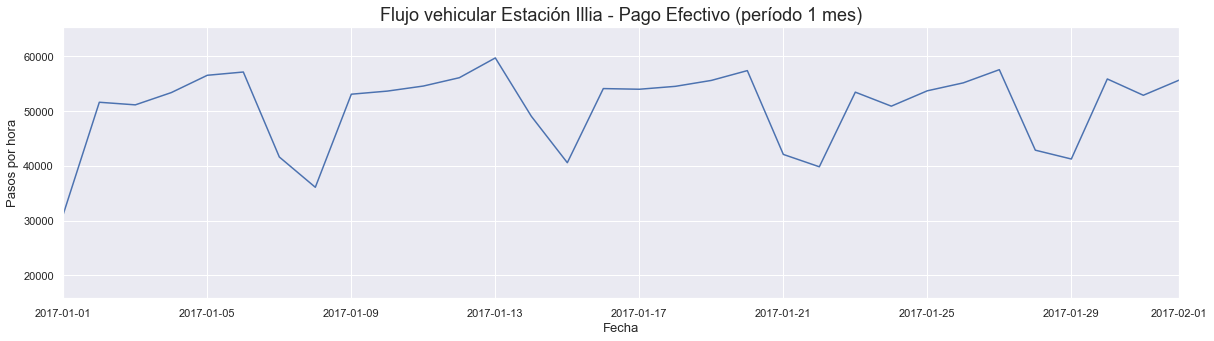

In [43]:
plt.figure(figsize=(20,5))

plt.plot(ds.index, ds.cantidad_pasos)

plt.title('Flujo vehicular Estación Illia - Pago Efectivo (período 1 mes)', size=18)
plt.xlabel('Fecha', size= 13)
plt.ylabel('Pasos por hora', size= 13)
plt.xlim(datetime.date(2017,1,1), datetime.date(2017,2,1))

plt.show()

**Figura 5.** Cantidad de pasos por día en la Estación Illia para forma de pago Efectivo en el período de 1 mes.

Podemos observar observar en el gráfico un ciclo que se repite con una frequencia semanal (estacionalidad).

Analizamos la Autocorrelación de la serie:

In [44]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

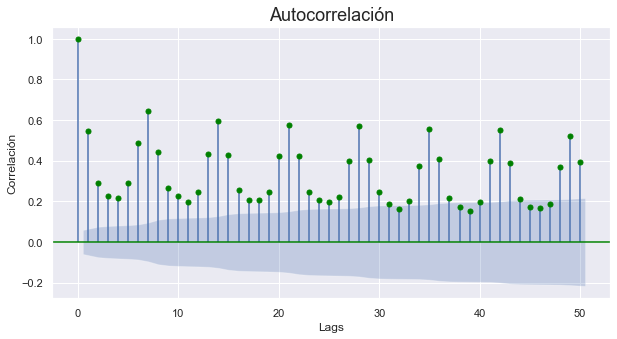

In [45]:
plt.rc("figure", figsize=(10,5))

plot_acf(ds['cantidad_pasos'], lags=50, color='green')

plt.title('Autocorrelación', size=18)
plt.xlabel('Lags')
plt.ylabel('Correlación')

plt.show();

**Figura 6.** Autocorrelaciones de la serie de 0 a 50 lags.

Podemos ver que la Autocorrelación es alta cada 7 días y que esta varía ciclicamente, manteniendo el mismo patrón semanalmente.

Analizamos la Autocorrelación Parcial:

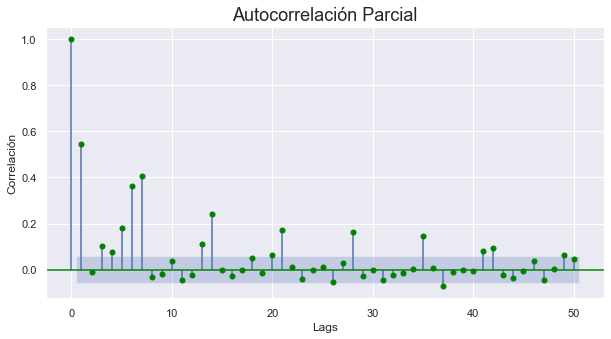

In [46]:
plt.rc("figure", figsize=(10,5))

plot_pacf(ds['cantidad_pasos'], lags=50, color='green')

plt.title('Autocorrelación Parcial', size=18)
plt.xlabel('Lags')
plt.ylabel('Correlación')

plt.show();

**Figura 7.** Autocorrelaciones Parciales de la serie de 0 a 50 lags.

El gráfico nos muestra que las autocorrelaciones realmente informativas son las de los primeros 7 lags y que el resto redundan en información respecto de estos. Luego mantiene cierta correlación cada 7 días probablemente debido a la Tendencia descendiente de la serie.

Analizamos confrontando la serie con el lag de mayor correlación (lag  7) en un Lagplot:

In [47]:
from pandas.plotting import lag_plot

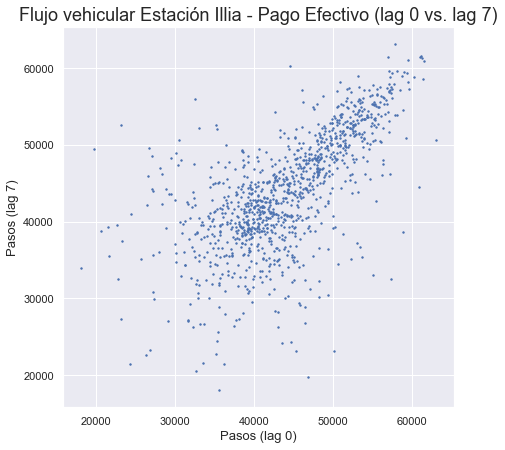

In [48]:
plt.figure(figsize=(7,7))
    
lag_plot(ds, lag=7, s=2, c='b')

plt.title('Flujo vehicular Estación Illia - Pago Efectivo (lag 0 vs. lag 7)', size=18)
plt.xlabel('Pasos (lag 0)', size= 13)
plt.ylabel('Pasos (lag 7)', size= 13)

plt.show();

**Figura 8.** Lagplot de la serie en el lag 0 y en el lag 7.

Los puntos concentrados en la diagonal de la **Figura 8** muestran  claramente la correlación entre el lag 0 y el lag 7 de la la variable.

Por lo visto en la **Figura 5** y analizado en los gráficos de Autocorrelación y Autocorrelación Parcial de las **Figuras 6 y 7** podemos concluir que la serie tiene una estructura cíclica que se repite en la misma frequencia por lo que confirmamos la serie es **estacional** (seasonal).



### Descomposición de la serie

Continuamos con el análisis de la serie viendo sus componentes: Tendencia , Nivel , Estacionalidad (Seasonality) y Residuales.

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [50]:
result = seasonal_decompose(ds['cantidad_pasos'], model = 'aditive')

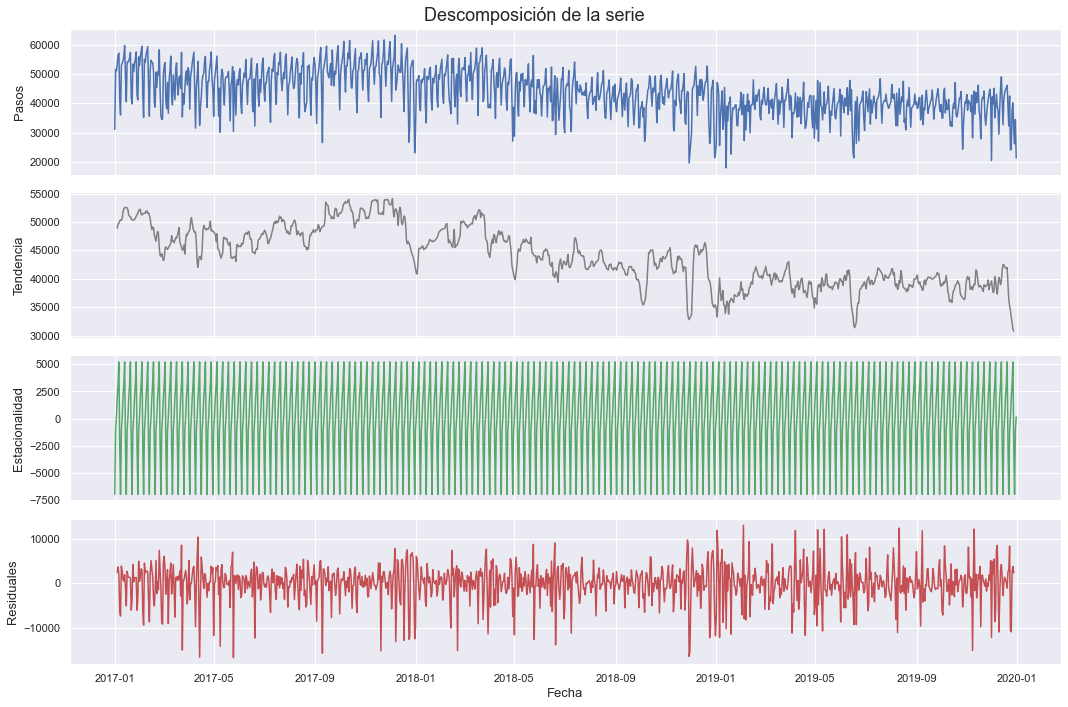

In [51]:
fig, ax = plt.subplots(4, 1, figsize=(15, 10), sharex=True) 
fig.suptitle('Descomposición de la serie', fontsize=18) 

ax[0].plot(result.observed)
ax[0].set_ylabel('Pasos', size=13)

ax[1].plot(result.trend, c='grey')
ax[1].set_ylabel('Tendencia', size=13)

ax[2].plot(result.seasonal, c='g')
ax[2].set_ylabel('Estacionalidad', size=13)

ax[3].plot(result.resid, c='r')
ax[3].set_ylabel('Residuales', size=13)
ax[3].set_xlabel('Fecha', size=13)

fig.tight_layout() 
fig.subplots_adjust(top=0.95) 

plt.show()

**Figura 9.** Lineplots de la serie original (azul) y sus componentes: Tendencia (gris), Componente estacional (verde) y Residuos (rojo).

El gráfico nos permite ver claramente la Tendencia decreciente (gris) y el ciclo con frecuencia continua del Componente Estacional (verde).

Para finalizar analizamos los estadísticos de la serie y graficamos su distribución:

In [52]:
ds.describe()

,cantidad_pasos
count,1095.000000
mean,43918.261644
std,7579.738335
min,18076.000000
25%,39107.500000
50%,43766.000000
75%,49514.500000
max,63127.000000


Podemos ver en el cuadro que la Media es cercana a 44000, lo que podríamos considerar nuestro Nivel. La desviación estándar y los percentiles muestran una dispersión razonable.


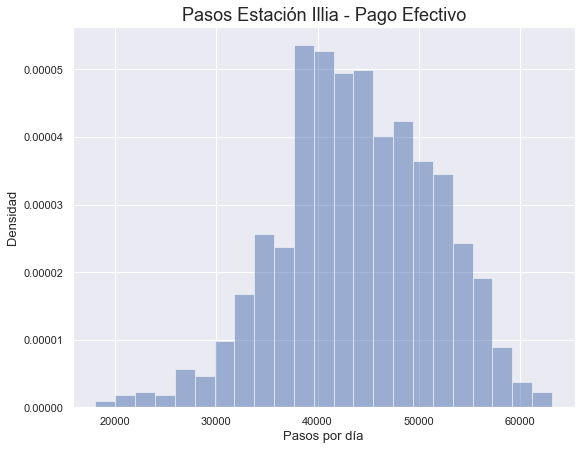

In [55]:
plt.figure(figsize=(9, 7))

plt.hist(ds['cantidad_pasos'], density=True, alpha=0.5, bins='auto')

plt.title('Pasos Estación Illia - Pago Efectivo', size=18)
plt.xlabel('Pasos por día', size=13)
plt.ylabel('Densidad', size=13)
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False) 

**Figura 10.** Distribución de los valores de la serie.

Podemos ver la distribución de la serie se aplana hacia la izquierda (left skew).

### Análisis de Componente Tendencia

Dado que la Tendencia de la serie es descendente (negativa), esto podría deberse no a una disminución del flujo vehicular, sino a que se este migrando a otras formas de pago.

La pregunta que intentaremos responder es: ¿La Tendencia negativa de la serie se debe a que disminuye la forma de pago Efectivo y aumenta la forma de pago por Telepase?

Utilizaremos la información auxiliar de otra forma de pago (Telepase) de la que disponemos para intentar llegar a una respuesta.

Definimos una función que realize filtrado del Dataset: 

In [56]:
def s_filter(data_selection, station, payment):
    mask = np.logical_and(data_selection.estacion==station, data_selection.forma_pago ==payment)
    data_selection = data_selection[mask]
    data_selection.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)
    data_selection['fecha2'] = pd.to_datetime(data_selection.fecha) + pd.to_timedelta(data_selection.hora_fin, unit = 'h')
    data_selection.drop(columns=['fecha','hora_fin'], inplace = True)
    data_selection.rename(columns = {'fecha2':'fecha'}, inplace = True) 
    data_selection.sort_values('fecha', inplace = True)
    data_selection.reset_index(drop=True, inplace = True)
    diario_selection = data_selection.resample('D', on = 'fecha').sum()
    diario_selection['cantidad_pasos'][diario_selection['cantidad_pasos']<1000] = np.nan 
    diario_selection = diario_selection.interpolate()
    
    return diario_selection

Definimos una función que grafique series:

In [57]:
def plot_series(s1, s2, title):
    
    plt.figure(figsize = (20,5))

    plt.plot(diario.index, s1.cantidad_pasos, labeL='Efectivo', zorder=2)
    plt.plot(diario.index, s2.cantidad_pasos, label='Telepase', zorder=1)

    plt.title(f'Flujo vehicular Estación {title} - Pago Efectivo / Telepase', size=18)
    plt.xlabel('Fecha', size= 13)
    plt.ylabel('Pasos', size= 13)
    plt.legend()
    
    plt.show()

Realizamos un nuevo filtrado del Dataset, igual al anterior salvo que elegiremos la forma de pago 'TELEPASE':

In [58]:
dataset_new = pd.concat([data_2019, data_2018, data_2017])

In [59]:
s_illia_tele = s_filter(dataset_new, 'Illia', 'TELEPASE')

Graficamos conjuntamente las series correspondientes a los pasos por la Estación Illia para pago EFECTIVO y TELEPASE:

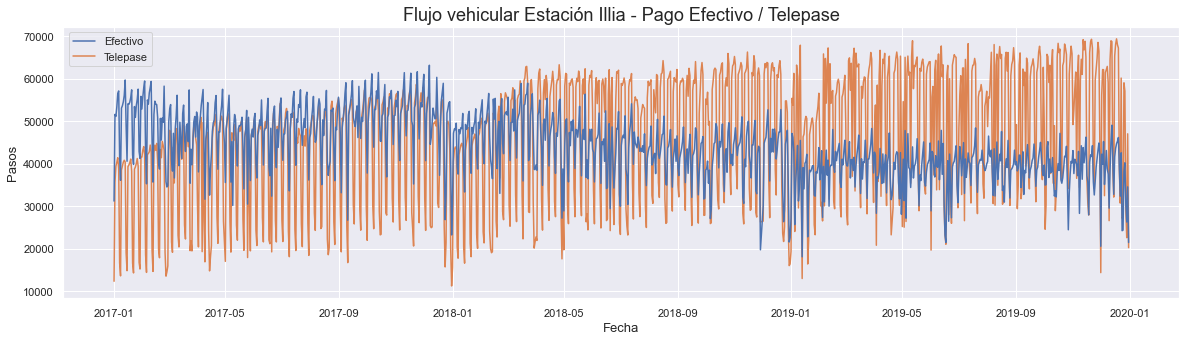

In [60]:
plot_series(ds, s_illia_tele, 'Illia')

**Figura 11.** Cantidad de pasos por día en la Estación Illia para forma de pago Efectivo (azul) y Telepase (naranja).

Efectivamente, el gráfico muestra como la Tendencia de la serie para el tipo de pago Telepase es ascendente a medida que desciende la de pago Efectivo.  
Podemos contestar nuestra pregunta afirmativamente, dado que la tendencia descendente de la serie de la Estación Illia forma de pago Efectivo se debe al aumento del pago por Telepase. 

### B Predicción a Futuro
---

In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

#### Selección de Métricas y Modelo Benchmark

Elegiremos entonces para evaluar la performance de nuestros modelos una de las métricas utilizadas comunmente en el análisis de Regresión:  

- **Raíz del error cuadrático medio (RMSE)**, que medirá la Desviación Standard de los valores residuales (diferencia entre valores predichos y valores reales).  
    Motivos de la elección:    
    - Utiliza la misma unidad que la variable independente (por lo que la preferiremos a MSE)
    - Su función es diferenciable, lo que hace mas fácil realizar operaciones matemáticas (por lo que la preferimos MAE)
    - Nos permitirá comparar distintos modelos frente a un Dataset.
    
    Notas:
    
    - Penaliza los errores mas altos, lo que la hace sensible a outliers (más que MAE).
    - Sirve solo para comparar el error en la predicción de distintos modelos frente a un mismo Dataset, y no entre distintos Datasets.   
   
   
Para crear nuestro modelo Benchmark, al que llamaremos **Modelo Persistence** (Modelo de Persistencia), utilizaremos un algoritmo de persistencia,  el cual utiliza el valor en el *timestep* actual en la serie (t) para predecir el valor esperado en el próximo *timestep* (t+1).

Y finalmente, para generar nuestros modelos utilizaremos el algoritmo **Random Forest Regressor** con parámetros optimizados mediante Grid Search con Cross Validation. Con este modelo probaremos dos metodologías distintas de predicción a Futuro:   
• One-Step Prediction  
• Multi-Step Prediction


Definimos una función que calcule el RMSE en base a la predicción de los modelos para la versión One-Step:

In [62]:
def model_results(X_train, y_train, X_test, y_test, model, name):
    pred_model_train = model.predict(X_train)
    pred_model_test = model.predict(X_test)

    print(f'{name}:')
    print('RMSE en Train Set: {:.4f}'.format(np.sqrt(mean_squared_error(pred_model_train, y_train))))
    print('RMSE en Test Set: {:.4f}'.format(np.sqrt(mean_squared_error(y_test, pred_model_test))))  

Definimos una función que calcule el RMSE en base a la predicción de los modelos para la verión Multi-Step:

In [63]:
def model_results_ms(y_test, y_ms_test_pred, name):
    frmt = lambda x: float("{:.4f}".format(x))
    print(f'{name}:\nRMSE en Test:',frmt(np.sqrt(mean_squared_error(y_test, y_ms_test_pred))))

Definimos una función que grafique simultaneamente para utilizar en One-Step Prediction:  
• La serie original.  
• El Train Set.  
• El Test Set.  
• La predicción del modelo

In [65]:
def full_graph(X_train, X_test, ds, model, name):   

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    data=ds 
    
    plt.figure(figsize=(25,5))

    plt.plot(data.index[:length_total], data[:length_total], color='grey', label = 'Test Set')
    plt.plot(data.index[:N_train + look_back], data[:N_train + look_back],'', color='mediumseagreen', label = 'Train Set')
    plt.plot(data.index[look_back: look_back + N_train], y_train_pred,'-', color='b', label = 'Predicción en Train')
    plt.plot(data.index[N_train+look_back: length_total-1], y_test_pred,'', color='r', label = 'Predicción en Test')

    plt.title(f'Entrenamiento y predicción a futuro One-Step\n Modelo {name}', size=18)
    plt.xlabel('Fecha', size=13)
    plt.ylabel('Pasos', size=13)
    plt.legend()

    plt.show()

Definimos la misma función para utilizar en Multi-Step Prediction:

In [66]:
def full_graph_ms(data, name):
    
    plt.figure(figsize=(25,6))

    plt.plot(data.index[:length_total], data[:length_total], color='grey', label = 'Test Set')
    plt.plot(data.index[:N_train + look_back], data[:N_train + look_back], color='green', label = 'Train Set')
    plt.plot(data.index[look_back: look_back + N_train], y_train_pred, color='b', label = 'Predicción en Train')
    plt.plot(data.index[N_train+look_back: length_total-1], y_ms_test_pred, color='red', label = 'Predicción en Test')

    plt.title(f'Entrenamiento y predicción a futuro Multi-Step\n Modelo {name}', size=18)
    plt.xlabel('Fecha', size=13)
    plt.ylabel('Pasos', size=13)
    plt.legend()

    plt.show()

Definimos una función para:  
• Graficar la Distribución de dichos errores,    
• Graficar la Dispersión de los Valores Reales versus los Valores Predichos,  
para utilizar en One-Step Prediction:

In [68]:
def model_graphs(X_train, y_train, X_test, y_test, model, name):
    
    model.fit(X_train ,y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
       
    plt.figure(figsize = (12,6))
    plt.suptitle(f'Modelo {name}', fontsize=18)

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 30, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 30, label = 'test')
    plt.title('Distribución de Errores', fontsize=16)
    plt.xlabel('Error', size=13)
    plt.ylabel('Densidad', size=13)
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()]),  
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.title('Dispersión del target', fontsize=16)
    plt.xlabel('Valores Reales', size=13)
    plt.ylabel('Valores Predichos', size=13)
    
    plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
    plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
    plt.gcf().axes[1].xaxis.get_major_formatter().set_scientific(False)
    plt.gcf().axes[1].yaxis.get_major_formatter().set_scientific(False)
            
    plt.tight_layout()
    plt.subplots_adjust(top=0.85) 

    plt.show()

Definimos la misma funcion para utilizar en Multi-Step Prediction:

In [69]:
def model_graphs_ms(X_train, y_train, X_test, y_test, model, name):
       
    plt.figure(figsize = (12,6))
    plt.suptitle(f'Modelo {name}', fontsize=18)

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 30, label = 'train')
    sns.distplot(y_test - y_ms_test_pred, bins = 30, label = 'test')
    plt.title('Distribución de Errores', fontsize=16)
    plt.xlabel('Error', size=13)
    plt.ylabel('Densidad', size=13)
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_ms_test_pred, s =2)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()]),  
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.title('Dispersión del target', fontsize=16)
    plt.xlabel('Valores Reales', size=13)
    plt.ylabel('Valores Predichos', size=13)
    
    plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
    plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
    plt.gcf().axes[1].xaxis.get_major_formatter().set_scientific(False)
    plt.gcf().axes[1].yaxis.get_major_formatter().set_scientific(False)
            
    plt.tight_layout()
    plt.subplots_adjust(top=0.85) 

    plt.show()

Definimos la misma funcion para utilizar con el Modelo Benchmark:

In [70]:
def model_graph_bm(y_test_pred, name):
    
    plt.figure(figsize = (12,6))
    plt.suptitle(f'Modelo {name}', fontsize=18)

    plt.subplot(1,2,1)
    sns.distplot(y_test - y_test_pred[:-1], bins = 30, label = 'test')
    plt.title('Distribución de Errores', fontsize=16)
    plt.xlabel('Error', size=13)
    plt.ylabel('Densidad', size=13)
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred[:-1], s=2)

    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()]),  
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.title('Dispersión del target', fontsize=16)
    plt.xlabel('Valores Reales', size=13)
    plt.ylabel('Valores Predichos', size=13)

    plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
    plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
    plt.gcf().axes[1].xaxis.get_major_formatter().set_scientific(False)
    plt.gcf().axes[1].yaxis.get_major_formatter().set_scientific(False)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85) 

    plt.show()

Definimos una función que grafique las distribuciones de los valores reales y predichos del target en One-Step Prediction:

In [71]:
def model_prediction_dist(X_test, model, name):

    prediction = model.predict(X_test)

    plt.figure(figsize=(11,6))

    sns.distplot(y_test, hist=True, kde=False)
    sns.distplot(prediction, hist=True, kde=False)
    
    plt.legend(labels=['Valores reales de pasos', 'Valores predichos de pasos'], prop={"size":12}, loc='upper left')
    plt.title(f'Modelo: {name}\n Valores reales vs. Valores predichos', size=17)
    plt.xlabel('Precio', size=13)
    plt.ylabel('Propiedades', size=13)
    
    plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
    plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

Definimos la misma funcion para utilizar en Multi-Step Prediction:

In [72]:
def model_prediction_dist_ms(X_test, model, name):
    plt.figure(figsize=(11,6))

    sns.distplot(y_test, hist=True, kde=False)
    sns.distplot(y_ms_test_pred, hist=True, kde=False)
    
    plt.legend(labels=['Valores reales de pasos', 'Valores predichos de pasos'], prop={"size":12}, loc='upper left')
    plt.title(f'Modelo: {name}\n Valores reales vs. Valores predichos', size=17)
    plt.xlabel('Precio', size=13)
    plt.ylabel('Propiedades', size=13)
    
    plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
    plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

Definimos una función que imprima los resultados del Grid Search:

In [73]:
def grid_results(grid):
    print('Mejores Hiperparámetros:', grid.best_params_)

Definimos una función que grafique la importancia de cada Feature para el entrenamiento de un modelo:

In [74]:
def feature_importance(model, nombre):
    
    df=pd.DataFrame(X)
    importances = model.feature_importances_
    columns = df.columns
    
    plt.figure(figsize=(25,5))
    
    sns.barplot(columns, importances)

    plt.title(f'Importancia de cada variable\n Modelo {nombre}', fontsize=18)
    plt.xlabel('Variables', fontsize=13)
    plt.ylabel('Importancia', fontsize=13)
    plt.show()

### Preparación de la serie para entrenamiento

In [75]:
data = ds['cantidad_pasos']
data.shape

(1095,)

In [76]:
look_back = 90

Creamos la matriz de features y el target con ceros:

In [77]:
N = data.shape[0] 
X = np.zeros((N - look_back -1,look_back))
y = np.zeros(N - look_back -1)            

Cargamos con las variables predictoras (Features 'X') y la variable a predecir (Target 'y'):

In [78]:
for i in range(X.shape[0]):
    X[i,:] = data.iloc[i:i+look_back]        
    y[i] = data.iloc[i+look_back]       

Realizamos un Train/Test split manual de los datos previo a crear nuestros modelos:

In [79]:
N_train = 2*365 - look_back 
N_test = 365               
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]    
y_train = y[:N_train]         

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]

Analizamos el formato de cada Dataframe y Serie generado:

In [80]:
print("Forma de X_train: {}".format(X_train.shape))
print("Forma de y_train: {}".format(y_train.shape)) 
print("Forma de X_test: {}".format(X_test.shape))
print("Forma de y_test: {}".format(y_test.shape))

Forma de X_train: (640, 90)
Forma de y_train: (640,)
Forma de X_test: (364, 90)
Forma de y_test: (364,)


### Estandarización

Finalmente realizamos el escalado de los datos:

In [81]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

### Modelo Benchmark  

Creamos las predicciones a Futuro del modelo Persistence:

In [82]:
y_test_pred_bm = y[-1 + N_train : N_train + N_test-1]

Graficamos la serie original junto a la predicción a futuro del modelo:

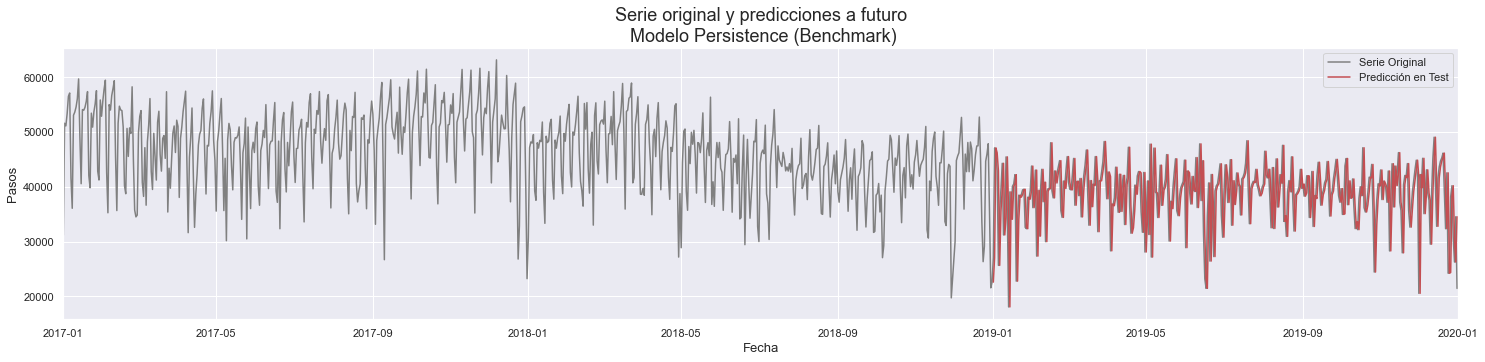

In [83]:
plt.figure(figsize=(25,5))

plt.plot(diario.index[:length_total], ds[:length_total], color='grey', label = 'Serie Original')
plt.plot(diario.index[N_train+look_back:length_total],y_test_pred_bm, color='r', label = 'Predicción en Test')

plt.title('Serie original y predicciones a futuro\n Modelo Persistence (Benchmark)', size=18) 
plt.xlabel('Fecha', size=13)
plt.ylabel('Pasos', size=13)
plt.xlim(datetime.date(2017,1,1), datetime.date(2020,1,1))

plt.legend()

**Figura 12.** Serie original completa (gris) junto a predicciones a futuro del modelo Benchmark Persistence (rojo).

Hacemos un acercamiento en la zona de predicción del modelo para visualizar mejor:

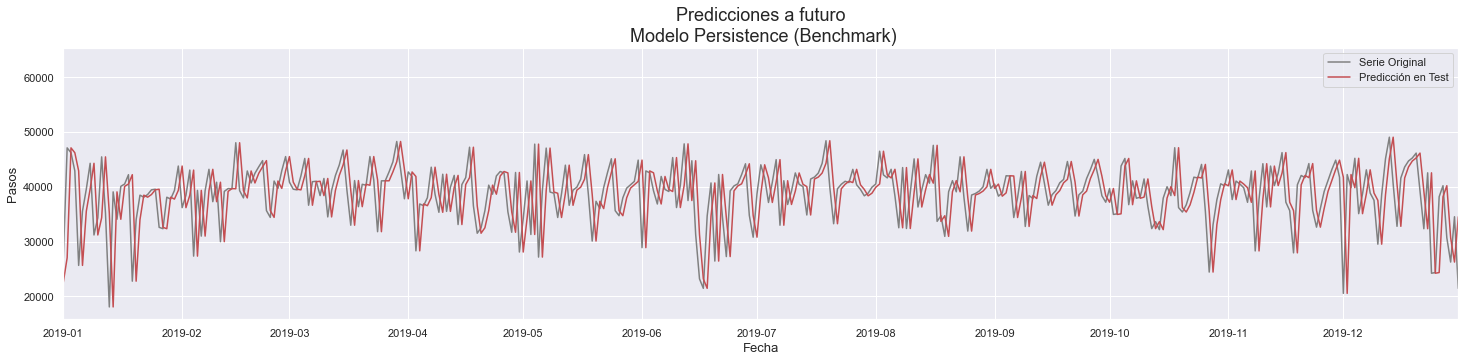

In [84]:
plt.figure(figsize=(25,5))

plt.plot(diario.index[:length_total], ds[:length_total], color='grey', label='Serie Original')
plt.plot(diario.index[N_train+look_back:length_total],y_test_pred_bm, color='r', label='Predicción en Test')

plt.title('Predicciones a futuro\n Modelo Persistence (Benchmark)', size=18) 
plt.xlabel('Fecha', size=13)
plt.ylabel('Pasos', size=13)
plt.xlim(ds.index[N_train + look_back], ds.index[length_total-1])

plt.legend()

**Figura 13.** Predicción a futuro del modelo Benchmark (rojo) junto al tramo correspondiente de la serie original (gris).

En el gráfico puede verse como el modelo Benchmark que creamos esta un paso detrás de la realidad: predice que el día siguiente habrá la misma cantidad de pasos del día presente, lo que genera la misma serie desfazada un día.

Evaluamos el modelo:

In [85]:
print('Modelo Persistence:')
print('RMSE en Test Set: {:.4f}'.format(np.sqrt(mean_squared_error(y_test, y_test_pred_bm[:-1]))))

Modelo Persistence:
RMSE en Test Set: 6633.9060


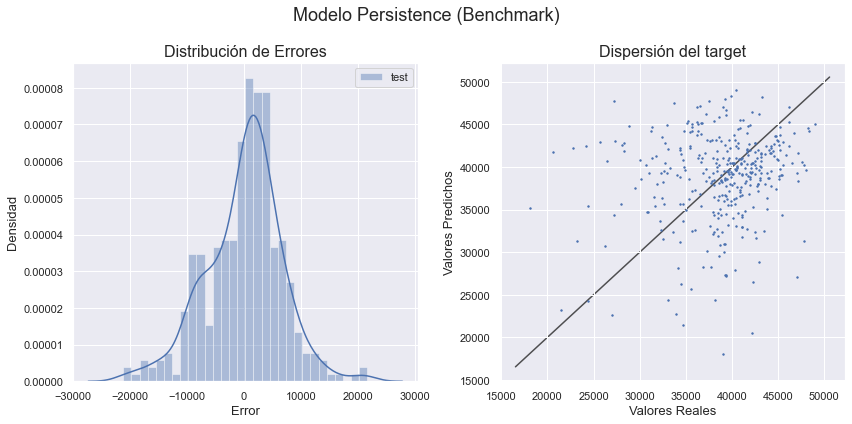

In [86]:
model_graph_bm(y_test_pred_bm, 'Persistence (Benchmark)')

**Figura 14.** Distribucion de los errores del modelo Bechmark Persistence (sobre Test Set) y Dispersión de los valores predichos del target vs. los valores reales (sobre Test Set)

Nuestro modelo logra un RMSE=6633.9060 en el Test. Su distribución de errores esta centrada en cero y es aproximadamente gaussiana aunque presenta tramos irregulares. La aproximación de puntos a la diagonal del gráfico de dispersión muestra sobrevaluación y subvaluación en todo el rango. El desempeño es el esperable por tratarse de un modelo básico y nos servirá como de base para comparar con el modelo mas avanzado con distintas versiones que entrenaremos.

## Random Forest  

Creamos y entrenamos el modelo con los hiperparámetros de default:

In [87]:
forest = RandomForestRegressor(random_state=42, n_jobs=-1)

In [88]:
forest.fit(X_train_sc, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

### • One-Step Prediction


In [89]:
model_results(X_train_sc, y_train, X_test_sc, y_test, forest, 'test')

test:
RMSE en Train Set: 1775.0356
RMSE en Test Set: 5175.2253


Intentaremos mejorar estos valores aún mas mediante el ajuste de los hiperparámetros antes de hacer un análisis más profundo.

### Ajuste de hiperparámetros

Realizamos un Grid Search con Cross Validation para obtener los valores de hiperparámetros que optimicen nuesto modelo:

Definimos la grilla con los hiperparámetros a testear:

In [124]:
param_grid_f = {'n_estimators': [100, 200, 400, 500], 
                'max_features': [30, 60, 89], 
                'max_depth': [5, 10, 20, 40, 60, None]}   

In [125]:
forest_tuned = RandomForestRegressor(random_state=42, n_jobs=-1)

In [126]:
grid_search_f = GridSearchCV(forest_tuned, param_grid_f, cv=5,  n_jobs=-1)

In [127]:
grid_search_f.fit(X_train_sc, y_train) 

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, 40, 60, None],
                         'max_features': [30, 60, 89],
                         'n_estimators': [100, 200, 400, 500]})

Verificamos los resultados del Grid Search:

In [128]:
grid_results(grid_search_f)

Mejores Hiperparámetros: {'max_depth': 40, 'max_features': 60, 'n_estimators': 200}


Creamos y entrenamos el modelo con los hiperparámetros indicados:

In [90]:
forest_tuned = RandomForestRegressor(max_features=60, n_estimators=200, max_depth=40, n_jobs=-1, random_state=42)

In [91]:
forest_tuned.fit(X_train_sc, y_train)

RandomForestRegressor(max_depth=40, max_features=60, n_estimators=200,
                      n_jobs=-1, random_state=42)

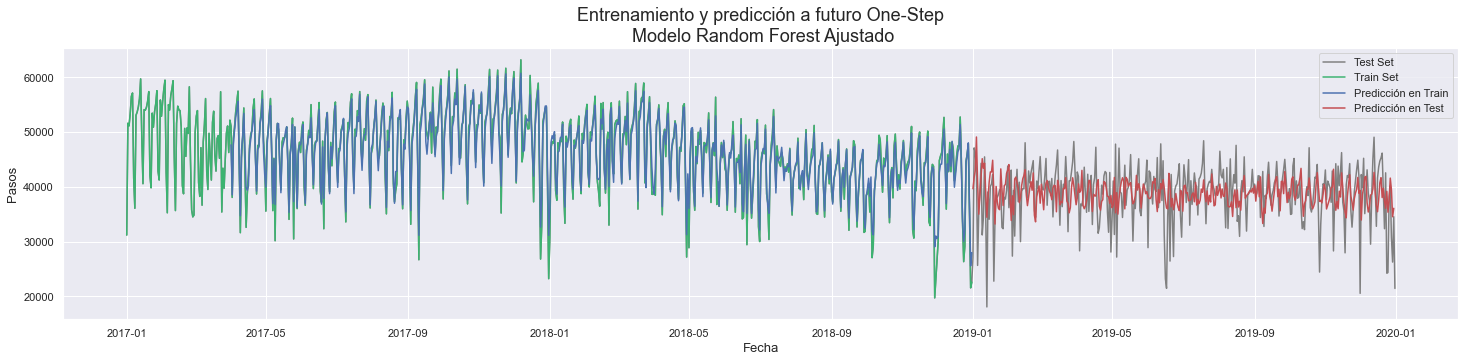

In [92]:
full_graph(X_train_sc, X_test_sc, ds, forest_tuned, 'Random Forest Ajustado')

**Figura 15.** Train Set (verde) y Test Set (gris) de la serie original junto a las predicciones en ambos Sets (azul para el Train y rojo para el Test).

Puede observarse la diferencia existente entre la predicción en el Train Set y la del Test Set, siendo el error de la primera claramente menor .

Evaluamos el modelo:

In [93]:
model_results(X_train_sc, y_train, X_test_sc, y_test, forest_tuned, 'Random Forest Ajustado')

Random Forest Ajustado:
RMSE en Train Set: 1744.9276
RMSE en Test Set: 5101.6182


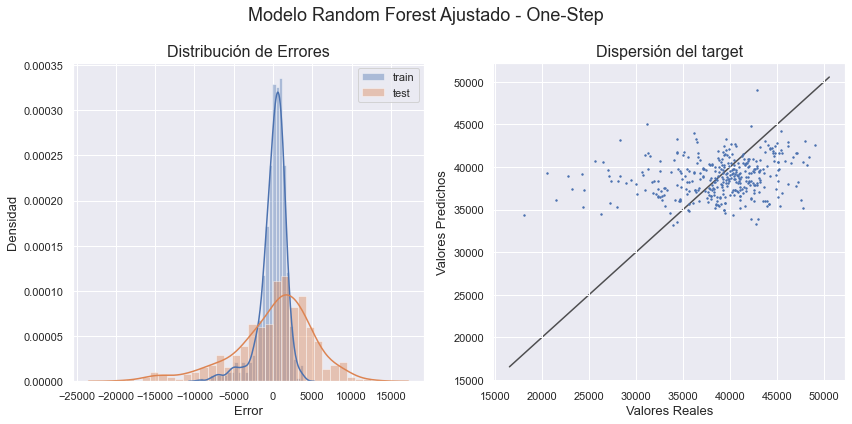

In [94]:
model_graphs(X_train_sc, y_train, X_test_sc, y_test, forest_tuned, 'Random Forest Ajustado - One-Step')

**Figura 16.** Distribuciones de los errores del Random Forest Ajustado (sobre ambos Sets) y Dispersión de los valores predichos del target vs. los valores reales (sobre Test Set).

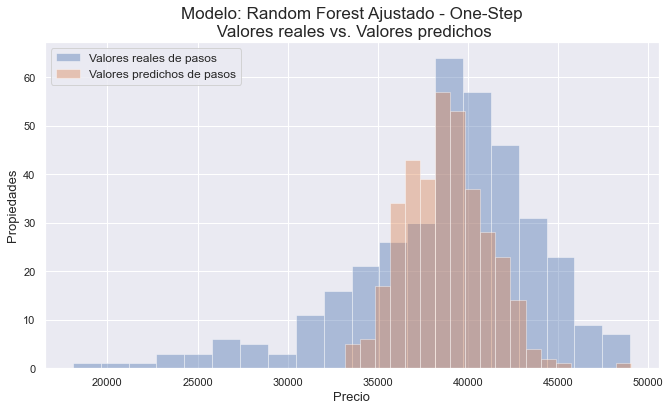

In [95]:
model_prediction_dist(X_test_sc, forest_tuned, 'Random Forest Ajustado - One-Step')

**Figura 17.** Distribuciones de los valores del target reales y predichos por el modelo Random Forest Ajustado (sobre Test Set).

El modelo Random Forest Ajustado en la versión One-Step Prediction logra un RMSE=5101.6182 en el Test Set, superando al modelo Benchmark. Las distribuciones de errores estan desplazadas hacia la derecha del cero y hay una alta varianza en en la correspondiente al Test Set. El gráfico de dispersión muestra que el modelo comienza sobrevaluando y a partir de los 37000 aproximadamente comienza mayoritariamente a subvaluar. En este gráfico como en el de distribución de los valores reales y predichos vemos como las predicciones a futuro se encuentran concentradas entro los 35000 y 45000. Las distribuciones de los valores son diferentes y podemos ver las limitaciones de nuestro modelo.

### • Multi-Step Prediction

Generamos las predicciones a futuro de nuestro modelo en version Multi-Step:

In [96]:
y_ms_test_pred = []
x = X_test_sc[0,:] 
for i in range(y_test.size):
    y_os_pred = forest_tuned.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)   
y_ms_test_pred = np.array(y_ms_test_pred)

In [97]:
y_train_pred = forest_tuned.predict(X_train_sc)

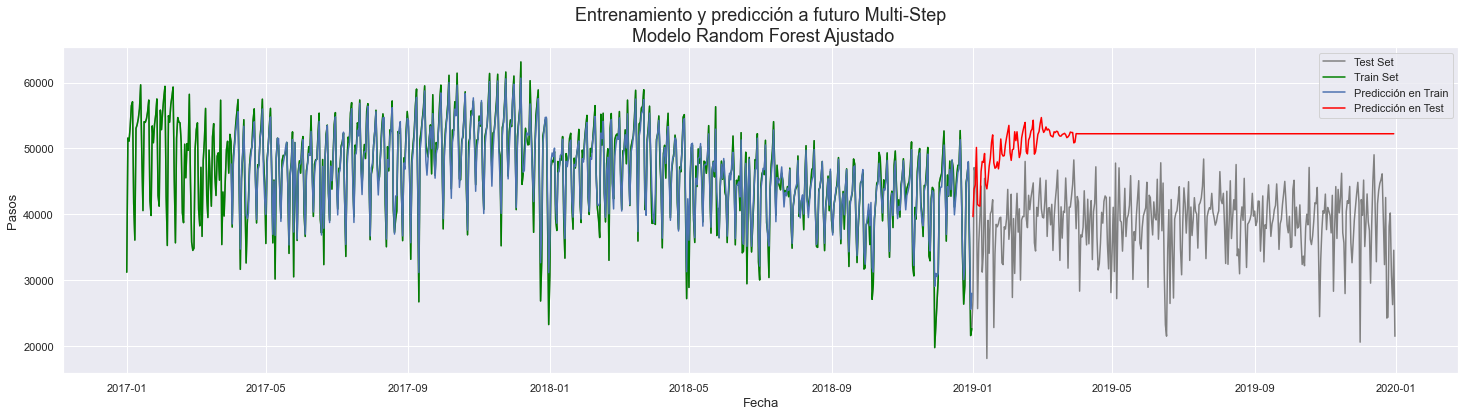

In [98]:
full_graph_ms(ds, 'Random Forest Ajustado')

**Figura 18.** Train Set (verde) y Test Set (gris) de la serie original junto a las predicciones en ambos Sets (azul para el Train y rojo para el Test) del modelo Random Forest en verión Multi-Step con datos escalados.

Al haber sido entrenado con datos estandarizados, el modelo en la versión Multi-Step tiene problemas ya que lo nuevos datos que recibe provenientes del target estan en la escala original (no estandarizados).  
Por esto entrenaremos nuevamente el algoritmo para esta versión de predicción con los datos sin estandarizar:

In [120]:
param_grid_f_nosc = {'n_estimators': [100, 200, 400, 500], 
                     'max_features': [30, 60, 89], 
                     'max_depth': [5, 10, 20, 40, 60, None]}   

In [121]:
forest_tuned_nosc = RandomForestRegressor(random_state=42, n_jobs=-1)

In [123]:
grid_search_f_nosc = GridSearchCV(forest_tuned_nosc, param_grid_f_nosc, cv=5, n_jobs=-1)

In [35]:
grid_search_f_nosc.fit(X_train, y_train) 

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, 40, 60, None],
                         'max_features': [30, 60, 89],
                         'n_estimators': [100, 200, 400, 500]})

Verificamos los resultados del Grid Search:

In [38]:
grid_results(grid_search_f_nosc)

Mejores Hiperparámetros: {'max_depth': 40, 'max_features': 60, 'n_estimators': 200}


In [99]:
forest_tuned_nosc = RandomForestRegressor(max_features=60, n_estimators=200, max_depth=40, n_jobs=-1, random_state=42)

In [100]:
forest_tuned_nosc.fit(X_train, y_train)

RandomForestRegressor(max_depth=40, max_features=60, n_estimators=200,
                      n_jobs=-1, random_state=42)

Generamos nuevamente las predicciones a futuro de nuestro modelo en version Multi-Step:

In [101]:
y_ms_test_pred = []
x = X_test[0,:] 
for i in range(y_test.size):
    y_os_pred = forest_tuned_nosc.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)   
y_ms_test_pred = np.array(y_ms_test_pred)

In [102]:
y_train_pred = forest_tuned_nosc.predict(X_train)

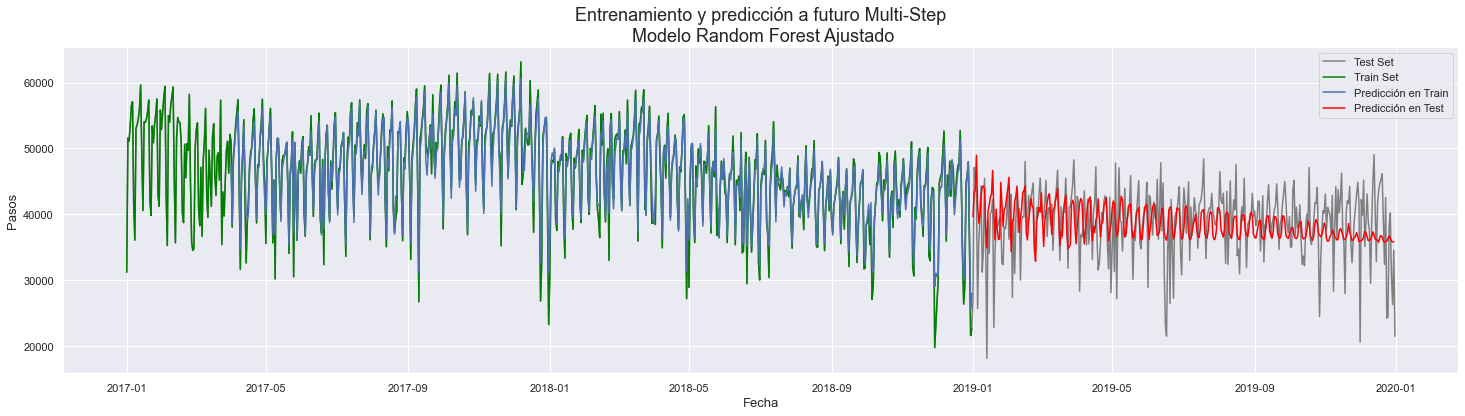

In [103]:
full_graph_ms(ds, 'Random Forest Ajustado')

**Figura 19.** Train Set (verde) y Test Set (gris) de la serie original junto a las predicciones en ambos Sets (azul para el Train y rojo para el Test) del modelo Random Forest en verión Multi-Step con datos sin escalar.

Ahora sí el modelo funciona correctamente. Podemos ver claramente el problema común de la predicción Multi-Step: la acumulación de errores  hace que el modelo vaya prediciendo a futuro cada vez peor.

Evaluamos el modelo:

In [104]:
model_results_ms(y_test, y_ms_test_pred, 'Random Forest Ajustado Multi-Step')

Random Forest Ajustado Multi-Step:
RMSE en Test: 5065.1897


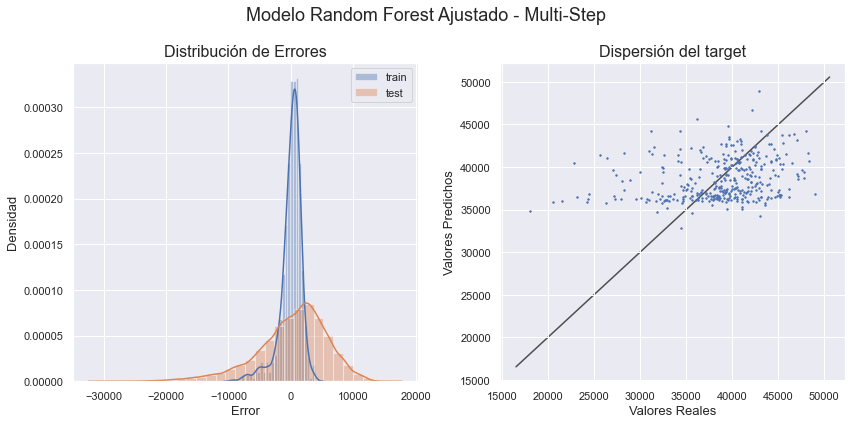

In [105]:
model_graphs_ms(X_train, y_train, X_test, y_test, forest_tuned_nosc, 'Random Forest Ajustado - Multi-Step')

**Figura 20.** Distribuciones de los errores del modelo Random Forest Ajustado (sobre ambos Sets) utilizando Multi-Step Prediction y Dispersión de los valores predichos del target vs. los valores reales (sobre Test Set).

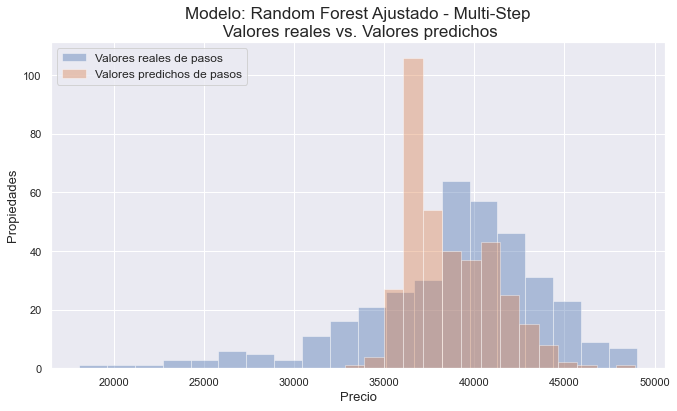

In [106]:
model_prediction_dist_ms(X_test, forest_tuned_nosc, 'Random Forest Ajustado - Multi-Step')

**Figura 21.** Distribuciones de los valores del target reales y predichos por el modelo Random Forest Ajustado (sobre Test Set) utilizzando Multi-Step Prediction.

Pese al problema marcado anteriormente, la versión Multi-Step del modelo obtiene un RMSE=5065.1897 superando levemente a la versión One-Step. Las distribuciones de los errores estan también desplazadas a la derecha del cero y vemos el mismo patrón de sobrevaluación/subvaluación en el gráfico de dispersión. En el Histograma de distribuciones de valores del target Real y Predicho vemos que estas continúan siendo diferentes y como hay una gran concentración de valores predichos en 36000.

Podemos concluir que el modelo no funciona bien con ninguna de las dos estrategias de predicción a futuro y que pese al resultado levemente superior de la versión Multi-Step, de tener que elegir optaríamos por la versión One-Step para seguir trabajando, no por sus resultado sino por rechazo a los problemas de la otra versión descriptos mas arriba. 

### Análisis de Importancia de Variables

Analizamos la importancia de cada variable en el armado del modelo

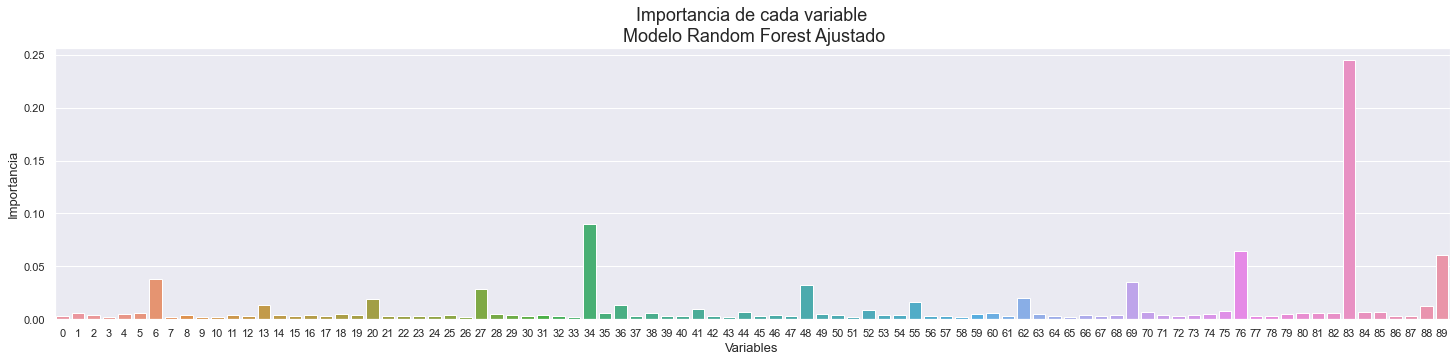

In [107]:
feature_importance(forest_tuned, 'Random Forest Ajustado')

**Figura 22.** Importancia de cada variable para el armado del modelo Random Forest Ajustado.

Las variables que muestran levemente mas importancia para nuestro modelo son las correspondientes a los multiplos de 7 (desfazados los nombres de las variables en el gráfico un número por comenzar en  0 el nombre asignado a cada variable). Esto se corresponde con la correlatividad encontrada cada 7 días y con el ciclo de frecuencia 7 (días) que describe la estacionalidad de la serie. La variable que definidamente mas importancia muestra es la correpondiente al múltiplo inmediatamente anterior a la predicción del modelo: los datos del mismo día de la semana anterior.

## Predicción 2020

Agregaremos a los datos la información correspondiente al año 2020. Si bien sabemos que debido a las restricciones generadas por la Pandemia Covid-19 el modelo no funcionará bien, igualmente realizaremos el entrenamiento y evaluación para poder analizar los resultados y la respuesta del modelo con las dos estrategias de predicción a futuro.

Cargamos el Dataset con la información del año 2020:

In [168]:
data_2020 = pd.read_csv('Datasets/flujo-vehicular-2020.csv', sep =',')

Filtramos los nuevos datos y elegimos los correspondientes a la estación Illia pago Efetivo:

In [169]:
diario_2020 = s_filter(data_2020, 'ILLIA', "Efectivo")

El Dataset 2020 tiene una columna distintea a los anteriores, la que quitaremos manualmente:

In [170]:
diario_2020.drop(columns=['dia_fecha'], inplace=True)

Concatenamos los nuevos datos del 2020 a los anteriores:

In [171]:
diario_new = pd.concat([ds, diario_2020])

Verificamos si hay fechas faltantes, para esto hacemos una copia del Dataset y generamos un índice numérico ya que no podemos analizar las fechas en formato `TimeIndex` y sí como un feature más:

In [112]:
ds_new_index = diario_new.copy()

In [113]:
ds_new_index.reset_index(inplace=True)
ds_new_index.head(2)

,fecha,cantidad_pasos
0,2017-01-01,31183.0
1,2017-01-02,51568.0


confirmamos que 'fecha' es ahora una variable más y no el índice, lo que nos permitirá verificar sus valores:

In [115]:
ds_new_index.shape

(1461, 3)

In [114]:
ds_new_index['date_check'] = ds_new_index.fecha.diff()
ds_new_index.date_check.value_counts() 

1 days    1460
Name: date_check, dtype: int64

Podemos ver que la diferencia entre días igual a 1 se mantiene a lo largo de toda la serie por lo tanto confirmamos que no hay valores faltantes en las fechas.  
Podemos continuar utilizando el Dataset anterior con fechas como índice.

Verificamos ahora si hay faltantes en al variable 'cantidad_pasos':

In [117]:
diario_new.isnull().sum()

cantidad_pasos    0
dtype: int64

### Preparación de la nueva serie para entrenamiento

Realizamos copia de trabajo:

In [172]:
ds_new = diario_new.copy()

In [173]:
data_new = ds_new['cantidad_pasos']
data_new.shape

(1461,)

In [174]:
look_back = 90

Creamos la matriz de features y el target con ceros:

In [175]:
N = data_new.shape[0] 
X = np.zeros((N - look_back -1,look_back))
y = np.zeros(N - look_back -1)            
print(X.shape, y.shape)

(1370, 90) (1370,)


Cargamos con las variables predictoras (Features 'X') y la variable a predecir (Target 'y'):

In [176]:
for i in range(X.shape[0]):
    X[i,:] = data_new.iloc[i:i+look_back]        
    y[i] = data_new.iloc[i+look_back]       

Realizamos un Train/Test split manual de los datos previo a crear nuestros modelos:

In [177]:
N_train = 3*365 - look_back 
N_test = 366               
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]    
y_train = y[:N_train]         

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]

Analizamos el formato de cada Dataframe y Serie generado:

In [178]:
print("Forma de X_train: {}".format(X_train.shape))
print("Forma de y_train: {}".format(y_train.shape)) 
print("Forma de X_test: {}".format(X_test.shape))
print("Forma de y_test: {}".format(y_test.shape))

Forma de X_train: (1005, 90)
Forma de y_train: (1005,)
Forma de X_test: (365, 90)
Forma de y_test: (365,)


### Estandarizacion

In [179]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

## Random Forest  

Creamos y entrenamos el modelo con los hiperparámetros de default:

In [180]:
forest_new = RandomForestRegressor(random_state=42, n_jobs=-1)

In [181]:
forest_new.fit(X_train_sc, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

### • One-Step Prediction


In [182]:
model_results(X_train_sc, y_train, X_test_sc, y_test, forest_new, 'test')

test:
RMSE en Train Set: 1782.2049
RMSE en Test Set: 18698.6766


Intentaremos mejorar estos valores aún mas mediante el ajuste de los hiperparámetros antes de hacer un análisis más profundo.

### Ajuste de hiperparámetros

Realizamos un Grid Search con Cross Validation para obtener los valores de hiperparámetros que optimicen nuesto modelo:

Definimos la grilla con los hiperparámetros a testear:

In [129]:
param_grid_f_new = {'n_estimators': [100, 200, 400, 500], 
                    'max_features': [30, 60, 89], 
                    'max_depth': [5, 10, 20, 40, 60, None]}   

In [130]:
forest_new_tuned = RandomForestRegressor(random_state=42, n_jobs=-1)

In [131]:
grid_search_f_new = GridSearchCV(forest_new_tuned, param_grid_f_new, cv=5,  n_jobs=-1)

In [132]:
grid_search_f_new.fit(X_train_sc, y_train) 

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, 40, 60, None],
                         'max_features': [30, 60, 89],
                         'n_estimators': [100, 200, 400, 500]})

Verificamos los resultados del Grid Search:

In [133]:
grid_results(grid_search_f_new)

Mejores Hiperparámetros: {'max_depth': 20, 'max_features': 30, 'n_estimators': 500}


Creamos y entrenamos el modelo con los hiperparámetros indicados:

In [129]:
forest_new_tuned = RandomForestRegressor(max_features=30, n_estimators=500, max_depth=20, n_jobs=-1, random_state=42)

In [130]:
forest_new_tuned.fit(X_train_sc, y_train)

RandomForestRegressor(max_depth=20, max_features=30, n_estimators=500,
                      n_jobs=-1, random_state=42)

In [131]:
model_results(X_train_sc, y_train, X_test_sc, y_test, forest_new_tuned, 'Random Forest Nuevo Ajustado')

Random Forest Nuevo Ajustado:
RMSE en Train Set: 1754.9561
RMSE en Test Set: 18783.0993


Dado que el modelo por los motivos explicados no debe estar funcionando bien y viendo que los resultados de este con los hiperparámetros del Grid Search empeoraron, continuaremos el análisis con el modelo sin Ajuste.

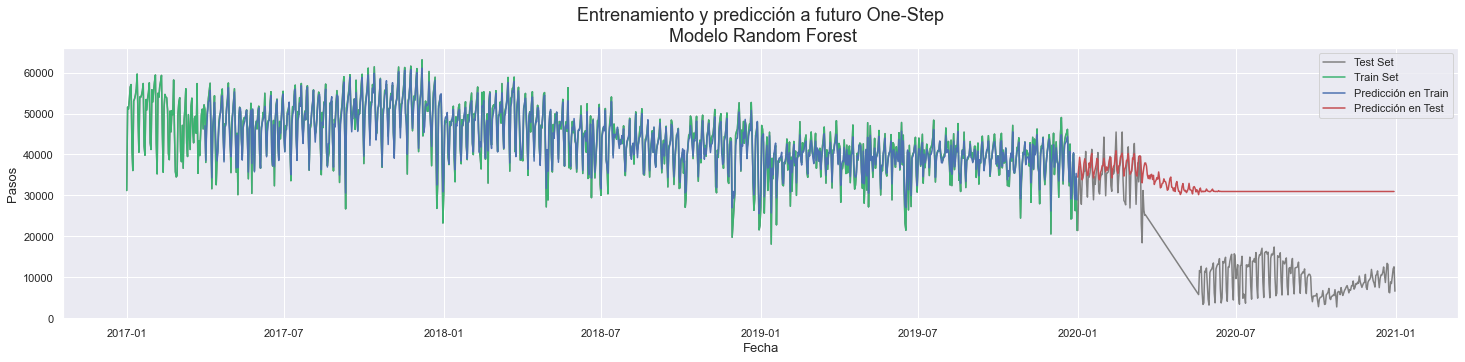

In [183]:
full_graph(X_train_sc, X_test_sc, data_new, forest_new, 'Random Forest')

**Figura 23.** Train Set (verde) y Test Set (gris) de la serie nueva con año 2020 incluido junto a las predicciones en ambos Sets (azul para el Train y rojo para el Test) del modelo Random Forest en verión One-Step con datos escalados.

Vemos como cambian drásticamente los datos correspondientes a marzo del año 2020 debido a las restricciones de la cuarentena por la pandemia del Covid-19. 

Mas allá de que la predicción a futuro del modelo como era de esperar es muy deficiente, como muestra su RMSE=18783.0993 en el Test Set y el gráfico de la **Figura 23**, es interesante ver como respondió:  
el modelo comienza funcionando normalmente con la información correspondiente a enero y febrero (previo a las restricciones) y comienza a fallar luego , debido a la gran diferencia entre la información con la que fue entrenado y la que recibio para predecir.  

### • Multi-Step Prediction

Generamos las predicciones a futuro de nuestro modelo en version Multi-Step, recordamos que utilizaremos los datos sin escalar:

Entrenamos el modelo con los datos sin escalar:

In [184]:
forest_new.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [185]:
y_ms_test_pred = []
x = X_test[0,:] 
for i in range(y_test.size):
    y_os_pred = forest_new.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)   
y_ms_test_pred = np.array(y_ms_test_pred)

In [186]:
frmt = lambda x: float("{:.4f}".format(x))
MSE = mean_squared_error(y_test, y_ms_test_pred)
print('RMSE en Test:',frmt(np.sqrt(MSE)))

RMSE en Test: 25784.7731


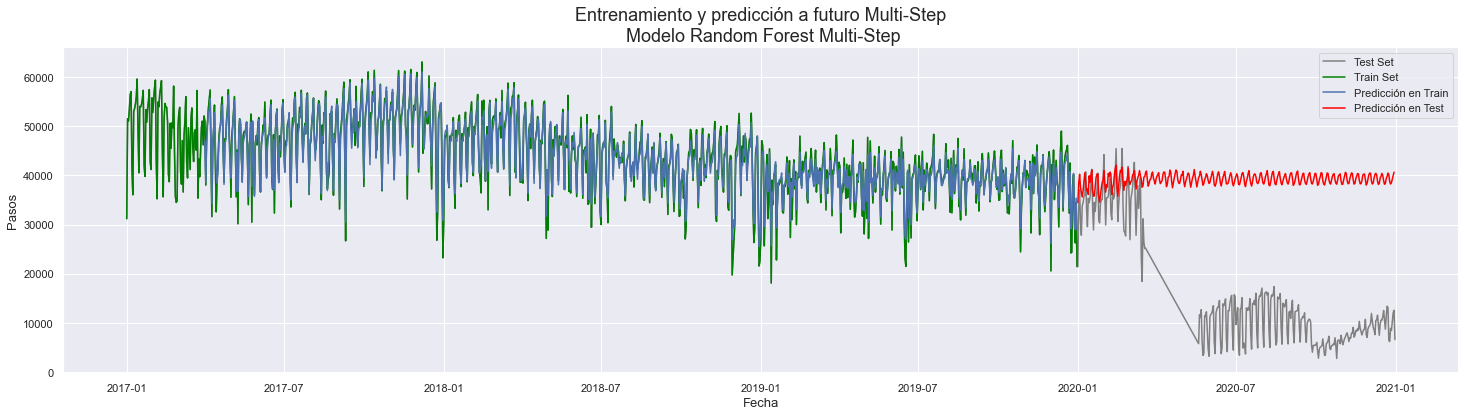

In [187]:
full_graph_ms(data_new, 'Random Forest Multi-Step')

**Figura 24.** Train Set (verde) y Test Set (gris) de la serie nueva con año 2020 incluido junto a las predicciones en ambos Sets (azul para el Train y rojo para el Test) del modelo Random Forest Ajustado en verión Multi-Step con datos sin escalar.

La versión Multi-Step obtiene resultados peores, con un RMSE=25784.7731 en el Test Set. Analizando el gráfico podemos ver como el modelo debido a su funcionamiento logra generar un ciclo nivelado en 40000 aproximadamente.

Podemos concluir que no obtuvimos buenos resultados dada la anormalidad de la situación generada por la Pandemia y la influencia directa en nuestros datos, que genera una gran diferencia entre la información con la que los agoritmos son entrenados y la que reciben nuestro modelos para predecir a futuro.

### C Para pensar, investigar y, opcionalmente, implementar - CORRECCION
---

Nos interesaría:

• Profundizar en conocimientos sobre el Dataset. Enumeraremos algunas de las preguntas que nos gustaría poder responder:

- A que se deben los Outliers encontrados e interpolados? A errores de carga, días feriados u otro motivo?
- Como evoluciona el flujo de tránsito en  la estación seleccionada a lo largo de la semana? 
- Como varía el flujo durante los días feriados?

podremos responder mediante la continuación del Análisis Exploratorio del Dataset (análisis de las fechas correspondientes, análisis de gráficos de distribución). Esto no solo nos permitirá contestar nuestras preguntas, sino que el resultado principal creemos que será la  posibilidad de generar nuevos Features.

• Mejorar el rendimiento del algoritmo utilizado en el presente trabajo, mediante la generación y agregado de features. Esperamos que esto genere un mejor resultado del modelo entrenado.

• Incrementar la cantidad de instancias de entrenamiento, mediante el agregado de datos de un año más. Un mayor Train Set creemos que también nos permitirá mejorar el rendimiento del modelo.

• Superar el rendimiento conseguido, mediante la selección de otro modelo acorde al problema y al dataset frente al que nos encontramos, junto al correpondiente ajuste de hiperparámetros. Creemos que la correcta selección sumado al trabajo que se realizará sobre el Dataset nos permitirá superar las métricas del modelo anterior.

Nota: aclaramos que respecto a la predicción del año 2020 no se esperan mejoras debido a los motivos anteriormente explicados.